In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Avoid warnings
import warnings
warnings.filterwarnings("ignore")

# Import CSV Files

In [2]:
#Checking the data
Cus_df =pd.read_csv("/kaggle/input/credit-card-exploratory-data-analysis/Customer Acqusition.csv")
Repay_df=pd.read_csv("/kaggle/input/credit-card-exploratory-data-analysis/Repayment.csv")
Spend_df=pd.read_csv("/kaggle/input/credit-card-exploratory-data-analysis/spend.csv")

#Spend_df.sample(5)

# Checking and cleaning data

In [3]:
# Checking for missing data

"""
No Missing Data 
Cus_df.isnull().sum()
Spend_df.isnull().sum()
"""

# Cus_df.shape (100,8)
#Spend_df.shape (1500,5)
#Repay_df.isnull().sum()

'\nNo Missing Data \nCus_df.isnull().sum()\nSpend_df.isnull().sum()\n'

In [4]:
#check num col and row in Repay_df
Repay_df.shape


#Drop Unnamed:4 column - it is uncessary columns
#Fill NAN with its index+1 in the columns SL No: - we might need it later on
Clean_Repay_df = Repay_df.drop(labels='Unnamed: 4', axis=1)
Clean_Repay_df['SL No:'] = Clean_Repay_df.index+1
Clean_Repay_df = Clean_Repay_df.dropna()

Cus_df = Cus_df.rename(columns={"Product":"Tier"})
Cus_df['Tier'] = Cus_df['Tier'].replace('Platimum', 'Platinum')

Spend_df['Type']= Spend_df['Type'].replace('PETRO','PETROL')

#Clean_Repay_df.shape
Cus_df['Customer'].shape

(100,)

In [5]:
#Additional Categories 

def agegroup (age):
    if age >=13 and age <18:
        return 'Teenager'
    elif age >= 18 and age <65:
        return 'Adults'
    elif age >= 65:
        return 'OlderAdults'
Cus_df['AgeGroup'] = Cus_df['Age'].apply(agegroup)


# Visualisation of the data

In [6]:
#Load Visualisation Plugin

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import plotly.express as px


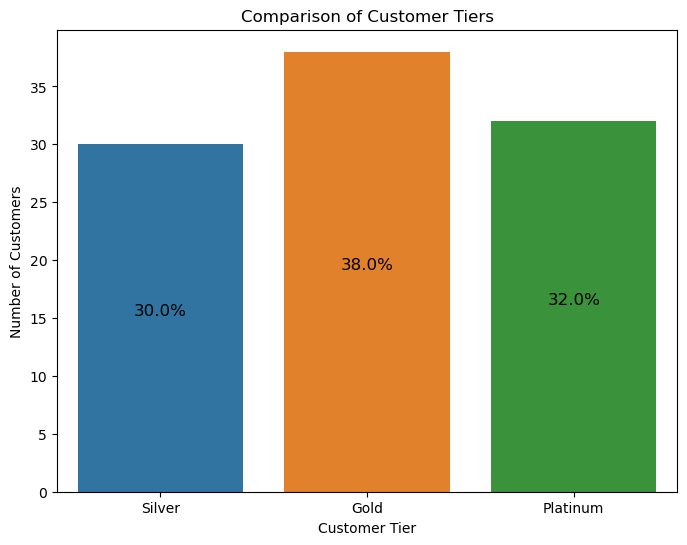

In [7]:
#What is % of each tier in our customer?

#Clean_Repay_df
#Cus_df
#Spend_df

# Create a countplot using seaborn
plt.figure(figsize=(8, 6))

# Calculate total number of customers
total_customers = len(Cus_df)

tier_order = ['Silver','Gold', 'Platinum'] 
ax = sns.countplot(data=Cus_df,x=Cus_df['Tier'],order=tier_order)

# Set labels and title
plt.xlabel('Customer Tier')
plt.ylabel('Number of Customers')
plt.title('Comparison of Customer Tiers')


# Add text labels on top of each bar
for p in ax.patches:
    percentage = p.get_height() / total_customers * 100
    ax.annotate(f'{percentage:.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

    
plt.show()

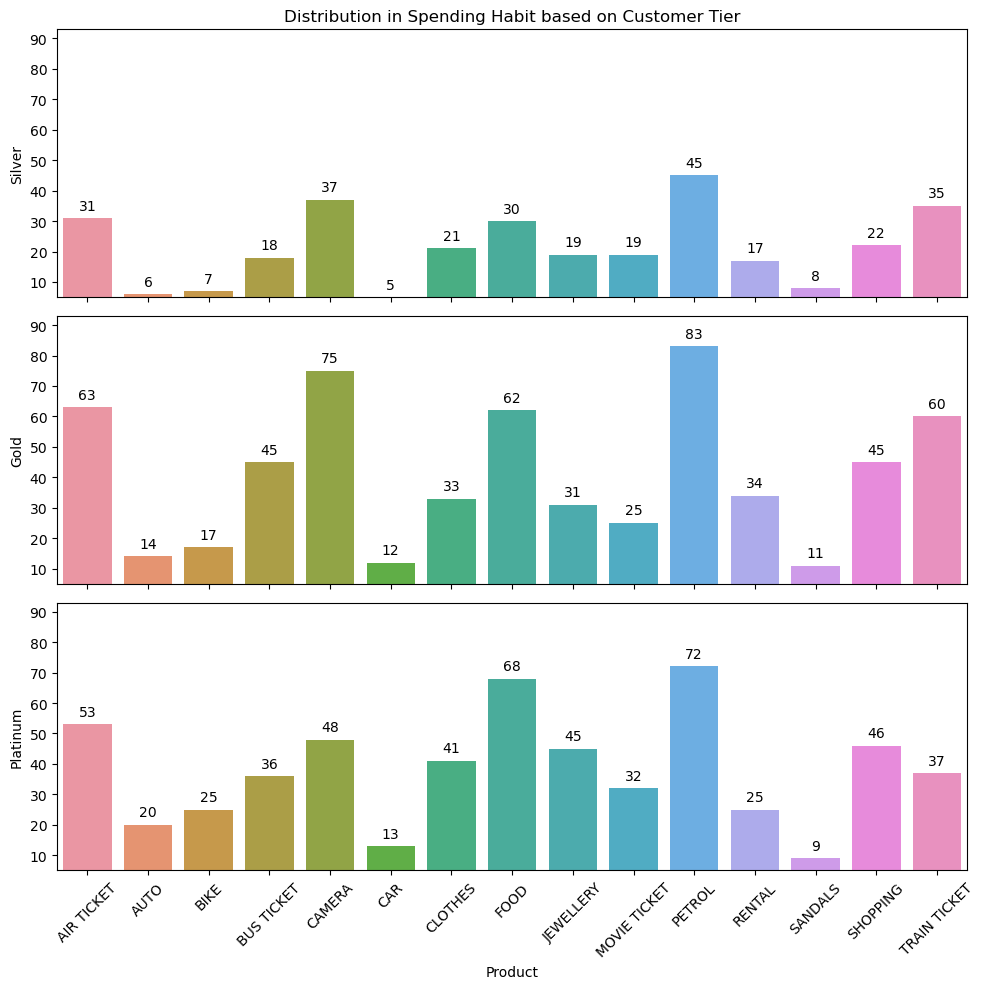

In [8]:
#What are their spending habit in differnt Teir?

# Cus_df
# Spend_df
# Clean_Repay_df

df_merge_col = pd.merge(Cus_df,Spend_df,on='Customer')

# Assuming 'Type' is the column containing the type of spend
data_merged = df_merge_col.groupby(['Tier', 'Type']).size().reset_index(name='Count')
order = data_merged['Type'].value_counts().index

# Filter data by a specific product, e.g., 'Platinum'
filtered_data_ax1 = data_merged[data_merged['Tier'] == 'Gold']
filtered_data_ax2 = data_merged[data_merged['Tier'] == 'Silver']
filtered_data_ax3 = data_merged[data_merged['Tier'] == 'Platinum']

# Set up the matplotlib figure
f,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10, 10), sharex=True)

sns.barplot(data=filtered_data_ax2, x='Type', y='Count',ax=ax1)
ax1.set_ylabel("Silver")

sns.barplot(data=filtered_data_ax1, x='Type', y='Count',ax=ax2)
ax2.set_ylabel("Gold")

sns.barplot(data=filtered_data_ax3, x='Type', y='Count',ax=ax3)
ax3.set_ylabel("Platinum")


ax1.set_title('Distribution in Spending Habit based on Customer Tier')
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('Product')

plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Set y-axis limits to min and max values
ax1.set_ylim(data_merged['Count'].min(), data_merged['Count'].max()+10)
ax2.set_ylim(data_merged['Count'].min(), data_merged['Count'].max()+10)
ax3.set_ylim(data_merged['Count'].min(), data_merged['Count'].max()+10)


# Annotate values on the bars
def annotate_bars(ax):
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

annotate_bars(ax1)
annotate_bars(ax2)
annotate_bars(ax3)

# Finalize the plot
plt.tight_layout(h_pad=1)
plt.show()


<Figure size 1000x1000 with 0 Axes>

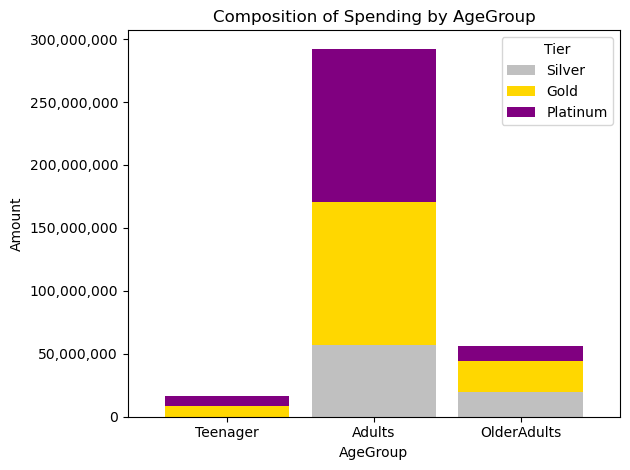

In [9]:
#What are the age group contain in each Teir?


# Calculate the sum of 'Amount' by 'AgeGroup' and 'Type'
amount_sum_by_agegroup_type = df_merge_col.groupby(['AgeGroup', 'Tier'])['Amount'].sum().reset_index()

# Pivot the data for creating a stacked bar chart
pivot_data = amount_sum_by_agegroup_type.pivot(index='AgeGroup', columns='Tier', values='Amount')

#Reoder the col of pivot_data Dataframe
column_order=['Silver','Gold','Platinum']
pivot_data = pivot_data[column_order]

# Reorder the rows of pivot_data DataFrame
agegroup_order = ['Teenager', 'Adults', 'OlderAdults']
pivot_data = pivot_data.loc[agegroup_order]

# # Calculate the percentage of each spending type within each AgeGroup
# total_sum_by_agegroup = pivot_data.sum(axis=1)
# pivot_data_percentage = (pivot_data.div(total_sum_by_agegroup, axis=0)) * 100


# Create a stacked bar chart using seaborn
plt.figure(figsize=(10, 10))

ax = pivot_data.plot(kind='bar', stacked=True, color=['silver','gold','purple']
                     ,width=0.85)


# Set labels and title
plt.xlabel('AgeGroup')
plt.ylabel('Amount')
plt.title('Composition of Spending by AgeGroup')

plt.xticks(rotation=0)  # Rotate x-axis labels for better visibility

# Format y-axis ticks with thousands separator
formatter = ticker.StrMethodFormatter('{x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.legend(title='Tier', loc='upper right')

# # Display percentage values on the stacked bars
# for p in ax.patches:
#     width, height = p.get_width(), p.get_height()
#     x, y = p.get_xy()
#     if height > 0:
#         ax.annotate(f'{p.get_height():.1f}%', 
#                     (x + width / 2, y + height), ha='center', va='bottom')

#End of Chart
plt.tight_layout()
plt.show()


In [10]:
#Where do most of our credit user lives?

#data
amount_sum_by_city_type=df_merge_col.groupby(['City','Tier'])['Amount'].sum().reset_index()
tier_counts_by_city = df_merge_col.groupby(['City', 'Tier']).size().reset_index(name='Tier_Count')

result_df = pd.merge(amount_sum_by_city_type, tier_counts_by_city, on=['City', 'Tier'])

fig = px.treemap(result_df,path=['City','Tier'],values='Amount',custom_data='Tier_Count')


# Update hover template for formatting
fig.update_traces(
#     hovertemplate='<b>%{label}</b><br>Value: $%{Amount[0]:,.2f}'
    hovertemplate='<b>%{label}</b><br>Amount: $%{value:,.2f}<br>Number of Tier: %{customdata[0]}'
)

# Update layout for better visualization
fig.update_layout(
    margin=dict(l=20, r=20, t=30, b=20),
    title='Sample Treemap',
)

# Show the plot
fig.show()


In [11]:
# Create a new DataFrame that sums up the Amount and Tier_Count for each City
summed_df = result_df.groupby('City').agg({
    'Amount': 'sum',
    'Tier_Count': 'sum'
}).reset_index()
#summed_df 

In [12]:
#How much is their credit card limited? Avg Med?
#How many spent within their credit card monthly?
#Amount of Spend/Repay in monthly.
#What product is spend on the most on each of the city?
#does spent or repay is related to Segments?
#Which company have most people is spenting or repay?



In [13]:
#How much is their credit card limited? Avg Med?

# Define is_skewed function
def is_skewed(mean, median):
    if mean > median:
        return 'Right'
    elif mean < median:
        return 'Left'
    else:
        return 'Symmetric'

# Group by 'Tier' and then aggregate
summary_stats = Cus_df.groupby('Tier')['Limit'].agg(['count','median','mean','std', 'sum']).round(2).reset_index() 
summary_stats['skew'] = summary_stats.apply(lambda row: is_skewed(row['mean'], row['median']), axis=1)
#summary_stats['var'] = summary_stats['var'].apply(lambda x:'{:,.0f}'.format(x))

summary_stats

#how does bank deal with values that have more then 2 decimal place?

,Tier,count,median,mean,std,sum,skew
0,Gold,38,500000.0,500000.00,0.00,19000000.0,Symmetric
1,Platinum,32,10002.0,139688.47,197344.55,4470031.0,Right
2,Silver,30,100001.5,166667.67,151619.15,5000030.0,Right


In [14]:
mode_values = Cus_df.groupby('Tier')['Limit'].describe().round(2).reset_index()
mode_values

,Tier,count,mean,std,min,25%,50%,75%,max
0,Gold,38.0,500000.00,0.00,500000.0,500000.0,500000.0,500000.0,500000.0
1,Platinum,32.0,139688.47,197344.55,10000.0,10001.0,10002.0,100003.0,500000.0
2,Silver,30.0,166667.67,151619.15,100000.0,100000.0,100001.5,100003.0,500000.0


In [15]:
#Clean_Repay_df
#Cus_df.nunique()
#Cus_df.info()
#Spend_df

# SandBox Area

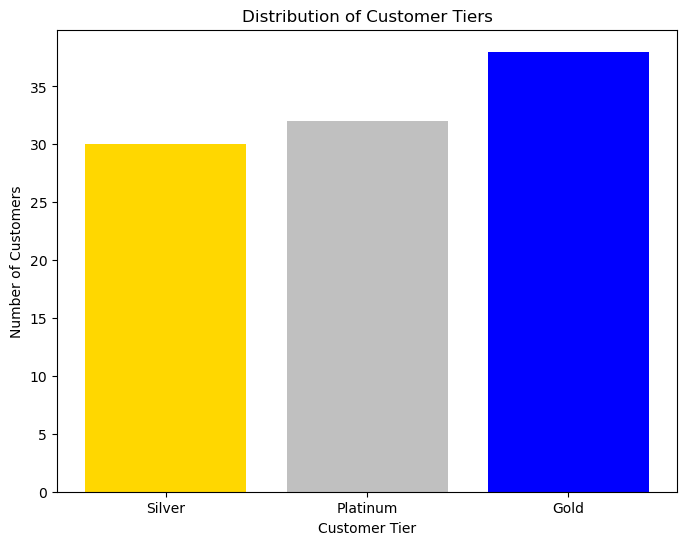

In [16]:
#Using PLT
# Count the occurrences of each tier
tier_counts = Cus_df['Tier'].value_counts().sort_values(ascending=True)

# Extract labels and counts
labels = tier_counts.index
counts = tier_counts.values

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['gold', 'silver', 'blue'])

# Set labels and title
plt.xlabel('Customer Tier')
plt.ylabel('Number of Customers')
plt.title('Distribution of Customer Tiers')

# Show the plot
plt.show()